# Find practices with similar demographic shapes

In [102]:
import matplotlib.pyplot as plt     
import seaborn as sns   
import scipy

MIN_LIST_SIZE = 3000  # Don't consider any practice smaller than this for similarity
target = "E85124"     # GP At Hand


%matplotlib inline
sns.set_style("white")

bands = ['0_4', '5_14', '15_24',
       '25_34', '35_44', '45_54', '55_64', '65_74',
       '75_plus']

In [3]:
def pyramid(full_df, code, month=None):
    df = full_df[full_df['practice_id'] == code]
    # put male on left
    for band in bands:
        df["xmale_" + band] = 0 - df["male_" + band]
    # plot every year in turn - write to file so we can animate
    if month:
        months = [month]
    else:
        months = sorted(df.month)
    for i, month in enumerate(months):
        plt.figure(i)
        df1 = df[df['date'] == month]
        df2 = pd.DataFrame(columns=['male', 'female'])
        #df2.columns = []
        for band in bands:
            df2.loc[band] = [df1["xmale_" + band].iloc[0], df1["female_" + band].iloc[0]]
        df2 = df2.reset_index()
        malemax = df2['male'].min() * -1.1
        plt.xlim(-malemax, malemax)
        sns.set_color_codes("pastel")
        bar_plot = sns.barplot(x="male", y="index", color="blue", label="male",data = df2)
        bar_plot = sns.barplot(x="female", y="index", color="red", label="female",data = df2)
        plt.show()
        # uncomment to save files for animation
        #plt.savefig('/tmp/myfig_%s.png' % month.strftime("%Y-%m-%d"))

In [4]:
import pandas as pd

df = pd.read_csv("stats.csv", usecols=['date', 'male_0_4', 'female_0_4', 'male_5_14', 'female_5_14',
       'male_15_24', 'female_15_24', 'male_25_34', 'female_25_34',
       'male_35_44', 'female_35_44', 'male_45_54', 'female_45_54',
       'male_55_64', 'female_55_64', 'male_65_74', 'female_65_74',
       'male_75_plus', 'female_75_plus', 'total_list_size', 'pct_id', 'practice_id'])

In [ ]:
# slice the current date
df2 = df[df['date'] == '2018-09-01']
# invert values for males so we can plot on one chart
for band in bands:
    df2["xmale_" + band] = 0 - df2["male_" + band]

# Exclude practices with very little prescribing

In [14]:
# One method for excluding non-standard practices
sql = """SELECT
  p.month,
  p.practice,
  items / total_list_size AS items_per_patient
FROM (
  SELECT
    practice,
    month,
    SUM(items) AS items
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard_latest_month`  
  GROUP BY
    practice,
    month ) p
INNER JOIN
  `ebmdatalab.hscic.practice_statistics` AS stats
ON
  p.practice = stats.practice
  AND stats.month = p.month"""
stats = pd.read_gbq(sql, project_id='ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [96]:
typical = stats[(stats['items_per_patient'] > stats['items_per_patient'].quantile(0.005))]

In [103]:
typical[typical['practice'] == target]

,month,practice,items_per_patient
4248,2018-09-01,E85124,0.263379


In [98]:
df2 = df2.merge(typical, how='right', left_on='practice_id', right_on='practice')

In [99]:
cols_to_compare = ['male_' + x for x in bands]
cols_to_compare += ['female_' + x for x in bands]

def normalise(row):
    "normalise to proportion max value so numbers are comparable"
    mx = max(row)
    return [x/mx for x in row]


def ks2(row, target_data=None):  
    return scipy.stats.ks_2samp(target_data, normalise(row[cols_to_compare]))

In [104]:
target_data = normalise(df2[df2['practice'] == target][cols_to_compare].iloc[0])
ks = df2.apply(ks2, axis=1, target_data=target_data).apply(pd.Series)
ks.columns = ['ks2', 'ks2_p']
df3 = df2.join(ks).sort_values('ks2')

In [105]:
# Filter for similarity
df4 = df3[(df3['ks2_p'] > 0.1) & (df3['total_list_size'] > MIN_LIST_SIZE)]

In [106]:
df4[['total_list_size', 'practice_id', 'ks2', 'ks2_p']].head()

,total_list_size,practice_id,ks2,ks2_p
2180,32569,E85124,0.000000,1.000000
6858,9260,Y02622,0.277778,0.425472
5451,10443,M85778,0.277778,0.425472
6923,8334,Y02946,0.277778,0.425472
1300,17173,C84117,0.277778,0.425472


In [107]:
practices = df2.join(df4[['ks2', 'ks2_p']], how='inner').sort_values('ks2')['practice_id']

E85124


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


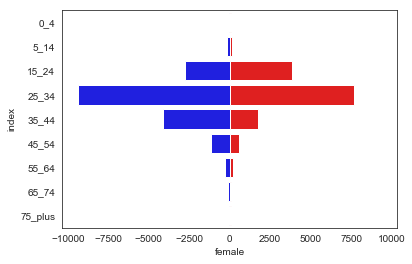

C82020


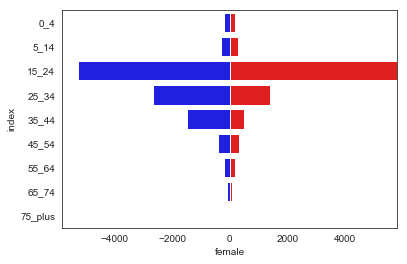

C84117


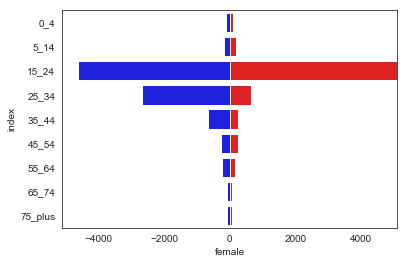

M85778


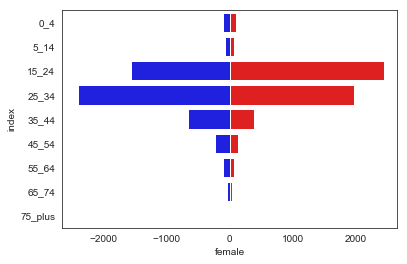

Y02002


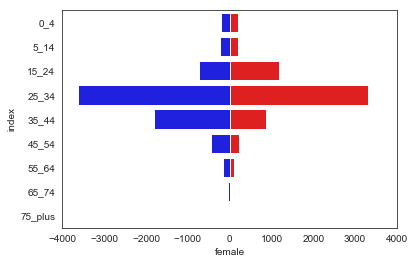

Y02622


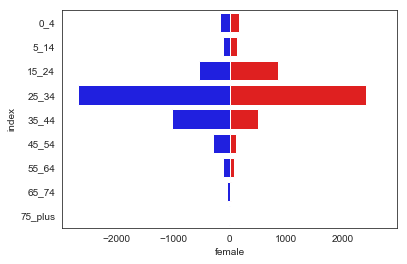

In [108]:
for practice in practices[0:6]:
    print(practice)
    pyramid(df, practice, '2018-09-01')